In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')
if not os.path.isdir('early_stopped'):
    os.makedirs('early_stopped')

In [2]:
# scaler for data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
def plot_loss_and_save(history, beta, fold):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('beta %s, fold %s model loss'%(beta,fold))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'upper right' )
    plt.ylim(0,1)
    plt.savefig('./figures/4A_beta_%s_fold_%s_loss.png'%(beta,fold))
    plt.show()

In [4]:
def plot_acc_and_save(history, beta, fold):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('beta %s, fold % accuracy'%(beta,fold))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'lower right' )
    plt.ylim(0,1)
    plt.savefig('./figures/4A_beta_%s_fold_%s_accuracy.png'%(beta,fold))
    plt.show()

In [5]:
NUM_CLASSES = 3

epochs = 1500
batch_size = 8
num_neurons = 10
seed = 10

num_attributes = 21
num_folds = 5

weight_decay=[0,1e-3,1e-6,1e-9,1e-12]

np.random.seed(seed)
tf.random.set_seed(seed)

histories={}
performances={}
losses={}

In [6]:
dataset = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X, Y = dataset[1:,:21], dataset[1:,-1].astype(int)
Y = Y - 1 #For python that start from 0

#Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed, shuffle=True)

#Scale based on training set 
X_test = scale(X_test,np.min(X_train,axis = 0),np.max(X_train, axis=0))
X_train = scale(X_train, np.min(X_train, axis = 0),np.max(X_train, axis = 0 ))

In [7]:
#Define K fold
kfold = KFold(n_splits=num_folds,shuffle=True,random_state = seed)

#Define model constructor
def build_model(beta_decay):
    #Model definition
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',input_dim = num_attributes,kernel_regularizer=keras.regularizers.l2(beta_decay)))
    model.add(keras.layers.Dense(NUM_CLASSES, activation ='softmax'))

    #default of sgd is lr = 0.01 so no need specify
    model.compile(optimizer='sgd',
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

In [8]:
for beta in weight_decay:
    fold = 0
    beta_histories = {}
    model_accuracies = []
    model_losses = []
    
    for train_idx, test_idx in kfold.split(X_train,Y_train):
        #Use early stopping to prevent overfitting
        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
        fold_csv_logger = keras.callbacks.CSVLogger('./early_stopped/4A_fold_%s_beta_%s.csv' % (fold,beta))
        callbacks = [fold_csv_logger, early_stopper]
        #Build model and fit for training
        model = build_model(beta)
        beta_histories['fold_%s'%fold] = model.fit(X_train[train_idx],Y_train[train_idx],
                                                   validation_data = (X_train[test_idx],Y_train[test_idx]),
                                                   epochs = epochs,
                                                   verbose = 0,
                                                   batch_size=batch_size,
                                                   callbacks=callbacks)
        
        best_accuracy = max(beta_histories['fold_%s'%fold].history['val_accuracy'])
        best_loss = min(beta_histories['fold_%s'%fold].history['val_loss'])
        
        #Evaluate only by models
        print("Best accuracy of beta = %s, fold %s: %.4f" %(beta,fold,best_accuracy))
        
        model_accuracies.append(best_accuracy*100)
        model_losses.append(best_loss)
        
        fold += 1 #Update fold number
                                                    
    #Update history of this beta into main history
    histories['beta_%s_histories'%beta]=beta_histories
    #Performances on average for this beta decay, amongst 5 folds
    performances['beta_%s'%beta]=model_accuracies
    losses['beta_%s'%beta]=model_losses
    print("%.2f%% (+/- %.2f%%)"%(np.mean(model_accuracies),np.std(model_accuracies)))
    print("%.4f (+/- %.4f)" % (np.mean(model_losses), np.std(model_losses)))
    #Repeat until all beta has been evaluated

Best accuracy of beta = 0, fold 0: 0.9060
Best accuracy of beta = 0, fold 1: 0.9329
Best accuracy of beta = 0, fold 2: 0.8926
Best accuracy of beta = 0, fold 3: 0.9057
Best accuracy of beta = 0, fold 4: 0.8956
90.66% (+/- 1.42%)
0.2433 (+/- 0.0351)
Best accuracy of beta = 0.001, fold 0: 0.9027
Best accuracy of beta = 0.001, fold 1: 0.9463
Best accuracy of beta = 0.001, fold 2: 0.8893
Best accuracy of beta = 0.001, fold 3: 0.9057
Best accuracy of beta = 0.001, fold 4: 0.8990
90.86% (+/- 1.97%)
0.2593 (+/- 0.0304)
Best accuracy of beta = 1e-06, fold 0: 0.8960
Best accuracy of beta = 1e-06, fold 1: 0.9362
Best accuracy of beta = 1e-06, fold 2: 0.8893
Best accuracy of beta = 1e-06, fold 3: 0.9057
Best accuracy of beta = 1e-06, fold 4: 0.8855
90.25% (+/- 1.82%)
0.2441 (+/- 0.0314)
Best accuracy of beta = 1e-09, fold 0: 0.9094
Best accuracy of beta = 1e-09, fold 1: 0.9396
Best accuracy of beta = 1e-09, fold 2: 0.8859
Best accuracy of beta = 1e-09, fold 3: 0.9091
Best accuracy of beta = 1e-09

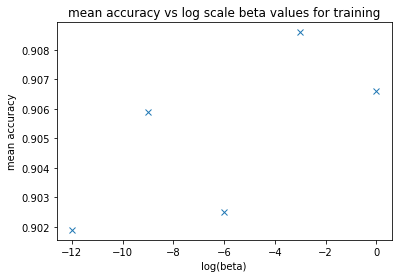

In [10]:
plt.plot([0,-3,-6,-9,-12],[0.9066,0.9086,0.9025,0.9059,0.9019],linestyle='None',marker = 'x')
plt.title('mean accuracy vs log scale beta values for training')
plt.ylabel('mean accuracy')
plt.xlabel('log(beta)')
plt.savefig('./early_stopped/mean_accuracy.png')
plt.show()